# Sentiment Analysis on Twitter Data using TweetEval

This notebook investigates sentiment analysis on Twitter data using the
publicly available **TweetEval – Sentiment** dataset. The objective is to
evaluate and compare traditional machine learning approaches with modern
transformer-based fine-tuning strategies, and to analyse the impact of
different fine-tuning techniques, training durations, and hyperparameter
optimisation.

The study focuses on understanding performance trade-offs between model
accuracy and computational efficiency.

---

## Task
- **Sentiment Analysis**
  - Classes: Negative, Neutral, Positive

---

## Models and Approaches Compared

- **TF-IDF + Logistic Regression**
  - Traditional machine learning baseline

- **BERT (Fully Fine-Tuned)**
  - Medium-sized transformer model
  - Trained with different numbers of epochs (2 and 3)
  - Further optimised using hyperparameter tuning

- **BERT with LoRA Fine-Tuning**
  - Parameter-efficient fine-tuning using Low-Rank Adapters (LoRA)
  - Compared against full fine-tuning under similar training conditions
  - Includes hyperparameter optimisation for adapter configuration

---

## Training and Analysis Components

- Comparison of different training epochs to study convergence behaviour
- Loss curve analysis for training and validation phases
- Confusion matrices and classification reports for detailed error analysis
- Hyperparameter tuning using validation performance
- Final evaluation on a held-out test set

---

## Evaluation Metrics

All models are evaluated using the following metrics:

- Accuracy
- **Macro-averaged Precision**
- **Macro-averaged Recall**
- **Macro-averaged F1-score**

Macro-averaged metrics are used to account for class imbalance and to ensure
fair evaluation across Negative, Neutral, and Positive sentiment classes.

---

## Model Selection Rationale: Why BERT and Not Other Transformer Models

In this study, BERT was selected as the base model for sentiment classification,
rather than experimenting with multiple transformer architectures. This choice
was guided by methodological clarity, task suitability, and practical
constraints.

### Suitability for Sentiment Classification

The TweetEval sentiment task involves short, informal text where contextual
understanding is essential. BERT’s bidirectional self-attention mechanism allows
it to model both left and right context simultaneously, making it highly
effective at capturing sentiment cues such as negation, emphasis, and contextual
polarity shifts commonly found in social media text.

### Medium-Sized Model Requirement

BERT-base (approximately 110 million parameters) satisfies the requirement of
using a medium-sized language model while remaining computationally feasible for
full fine-tuning, parameter-efficient fine-tuning (LoRA), and hyperparameter
optimisation. Larger models would significantly increase training cost without
guaranteed proportional performance gains for this task.

### Strong Research Baseline and Reproducibility

BERT is one of the most widely studied and well-documented transformer models in
natural language processing. Its extensive use in prior research provides a
strong and reliable baseline, enabling meaningful comparison between fine-tuning
strategies and improving experimental reproducibility.

### Controlled Comparison of Fine-Tuning Strategies

A key objective of this study is to compare **full fine-tuning** with
**parameter-efficient fine-tuning (LoRA)**. Using a single base architecture
ensures that performance differences can be attributed to the fine-tuning
strategy itself rather than architectural variations between models.

### Why Other Models Were Not Used

Alternative transformer models such as RoBERTa or DeBERTa were not included to
limit experimental complexity and computational overhead. While these models may
offer marginal performance improvements, their inclusion would not directly
strengthen the core research question, which focuses on analysing fine-tuning
behaviour rather than comparing architectures.

Overall, BERT provides an optimal balance between performance, interpretability,
computational efficiency, and methodological clarity for this investigation.

## Dataset: TweetEval – Sentiment

TweetEval is a benchmark dataset designed for sentiment analysis on Twitter data.  
It is publicly available via the Hugging Face Datasets library and includes predefined splits.

### Dataset Splits
- **Training set**: Used to train the models
- **Validation set**: Used for model selection and hyperparameter tuning
- **Test set**: Used only for final evaluation

### Label Mapping
- 0 → Negative
- 1 → Neutral
- 2 → Positive

The availability of fixed splits ensures fair and reproducible evaluation.

In [1]:
!pip -q install -U datasets transformers accelerate scikit-learn matplotlib seaborn

import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 13.1 MB/s eta 0:00:00
Running on: cuda


In [2]:
dataset = load_dataset("tweet_eval", "sentiment")

print("Train size:", len(dataset["train"]))
print("Validation size:", len(dataset["validation"]))
print("Test size:", len(dataset["test"]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train size: 45615
Validation size: 2000
Test size: 12284


## Exploratory Data Analysis (EDA)

Before training any machine learning or deep learning models, it is important to understand the dataset.
In this section, we explore the TweetEval Sentiment dataset to understand:

- Dataset structure and features
- Sample tweets
- Class label distribution
- Potential class imbalance

This analysis helps justify model choices and evaluation metrics.

In [3]:
import pandas as pd

df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

print("TRAIN INFO")
print(df_train.info(), "\n")

print("VALIDATION INFO")
print(df_val.info(), "\n")

print("TEST INFO")
print(df_test.info())

TRAIN INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45615 non-null  object
 1   label   45615 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 712.9+ KB
None 

VALIDATION INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None 

TEST INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12284 non-null  object
 1   label   12284 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.1+ KB
None


In [4]:
# Display dataset structure and features
print("Dataset splits:")
print(dataset)

print("\nFeatures:")
print(dataset["train"].features)

Dataset splits:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Features:
{'text': Value('string'), 'label': ClassLabel(names=['negative', 'neutral', 'positive'])}


### Dataset Features

The TweetEval Sentiment dataset contains the following fields:

- **text**: The raw tweet text
- **label**: Sentiment label
  - 0 → Negative
  - 1 → Neutral
  - 2 → Positive

In [5]:
# Show first 5 samples from training set
for i in range(5):
    print(f"Tweet {i+1}:")
    print("Text :", dataset['train'][i]['text'])
    print("Label:", dataset['train'][i]['label'])
    print("-" * 60)

Tweet 1:
Text : "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Label: 2
------------------------------------------------------------
Tweet 2:
Text : "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
Label: 1
------------------------------------------------------------
Tweet 3:
Text : Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
Label: 1
------------------------------------------------------------
Tweet 4:
Text : Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
Label: 1
------------------------------------------------------------
Tweet 5:
Text : @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
Label: 2
----------------------------------------------

### Sentiment Label Distribution

Next, we analyze how sentiment labels are distributed across the dataset.
This helps detect class imbalance, which can affect model performance.

In [6]:
import pandas as pd
label_df = pd.DataFrame({"label": dataset["train"]["label"]})

# Map label IDs to names
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
label_df["sentiment"] = label_df["label"].map(label_map)

# Count samples per class
label_counts = label_df["sentiment"].value_counts()
print(label_counts)

sentiment
Neutral     20673
Positive    17849
Negative     7093
Name: count, dtype: int64


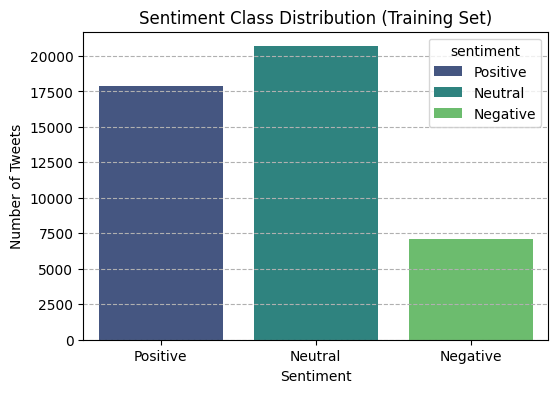

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=label_df["sentiment"], hue=label_df["sentiment"], palette="viridis", legend=True)
plt.title("Sentiment Class Distribution (Training Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis="y", linestyle="--")
plt.show()

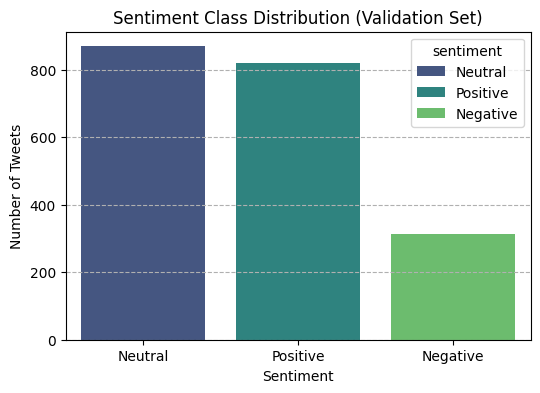

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame for validation labels
val_label_df = pd.DataFrame({"label": dataset["validation"]["label"]})
val_label_df["sentiment"] = val_label_df["label"].map(label_map)

# Plot validation set distribution
plt.figure(figsize=(6,4))
sns.countplot(x=val_label_df["sentiment"], hue=val_label_df["sentiment"], palette="viridis", legend=True)
plt.title("Sentiment Class Distribution (Validation Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis="y", linestyle="--")
plt.show()

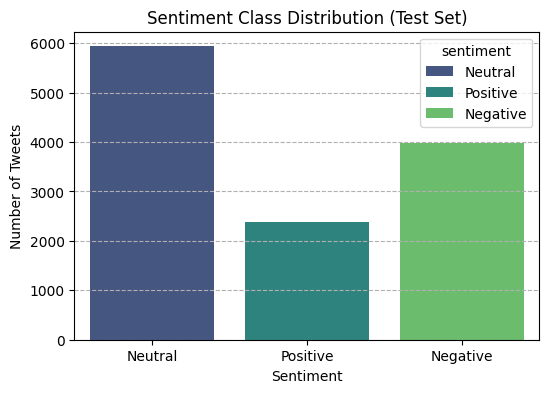

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame for test labels
test_label_df = pd.DataFrame({"label": dataset["test"]["label"]})
test_label_df["sentiment"] = test_label_df["label"].map(label_map)

# Plot test set distribution
plt.figure(figsize=(6,4))
sns.countplot(x=test_label_df["sentiment"], hue=test_label_df["sentiment"], palette="viridis", legend=True)
plt.title("Sentiment Class Distribution (Test Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis="y", linestyle="--")
plt.show()

/tmp/ipython-input-3294939507.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-3294939507.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-3294939507.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


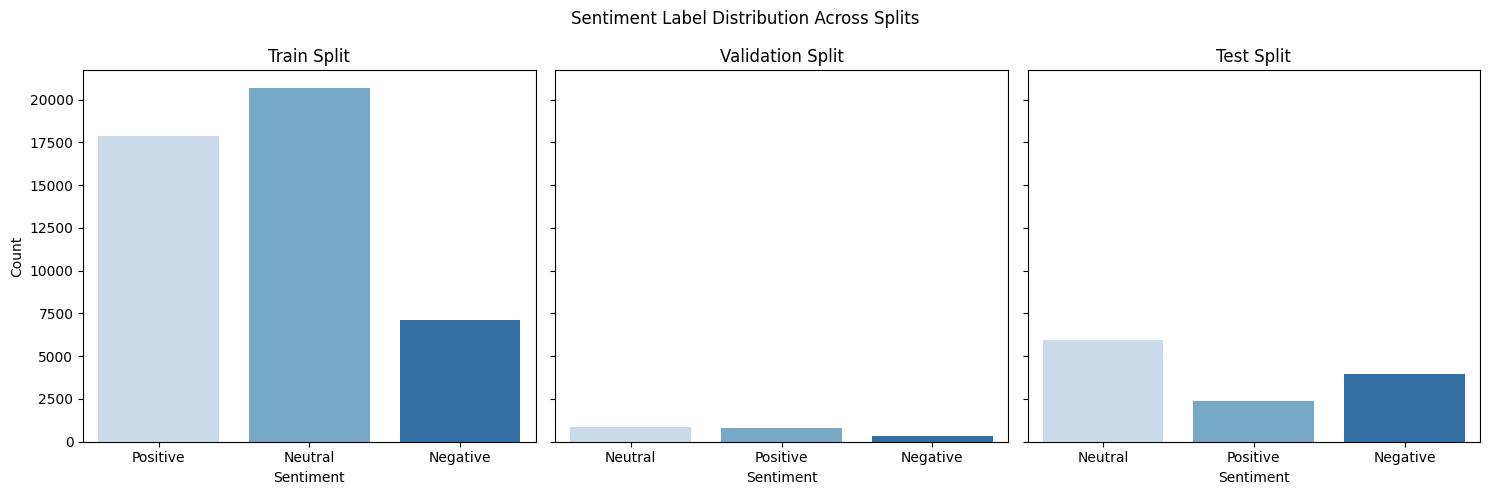

In [10]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for ax, df, name in zip(
    axes,
    [df_train, df_val, df_test],
    ["Train", "Validation", "Test"]
):
    sns.countplot(
        x=df["label"].map(label_map),
        ax=ax,
        palette="Blues"
    )
    ax.set_title(f"{name} Split")
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")

plt.suptitle("Sentiment Label Distribution Across Splits")
plt.tight_layout()
plt.show()

### Tweet Length and Word Count Statistics

We compute the number of characters and words per tweet to understand
the textual complexity of each dataset split.

In [11]:
def add_length_features(df):
    df["char_length"] = df["text"].apply(len)
    df["word_count"] = df["text"].apply(lambda x: len(x.split()))
    return df

df_train = add_length_features(df_train)
df_val   = add_length_features(df_val)
df_test  = add_length_features(df_test)

df_train[["char_length", "word_count"]].describe()

,char_length,word_count
count,45615.000000,45615.000000
mean,106.932851,19.237444
std,26.251517,4.935990
min,10.000000,1.000000
25%,89.000000,16.000000
50%,113.000000,20.000000
75%,128.000000,23.000000
max,200.000000,35.000000


### Tweet Length Distribution

This plot shows the distribution of tweet lengths (in characters)
for training, validation, and test splits.

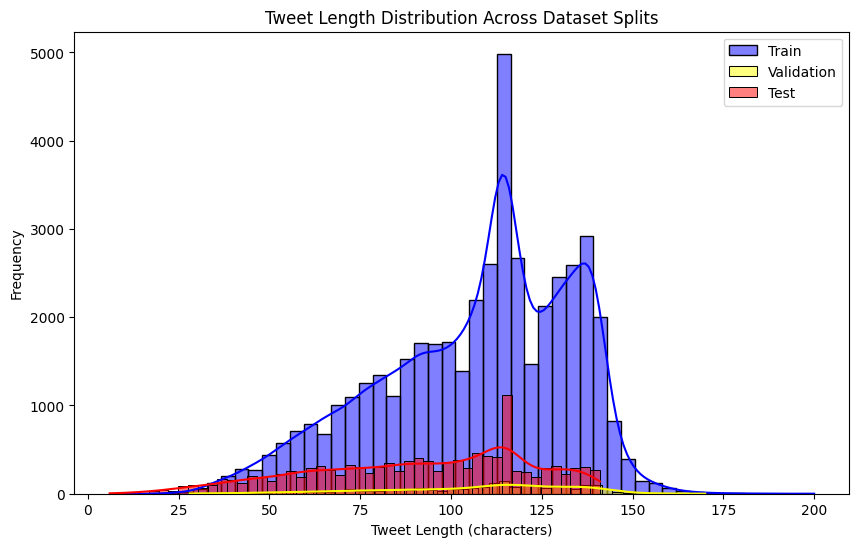

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.histplot(df_train["char_length"], bins=50, color="blue", label="Train", kde=True)
sns.histplot(df_val["char_length"], bins=50, color="yellow", label="Validation", kde=True)
sns.histplot(df_test["char_length"], bins=50, color="red", label="Test", kde=True)

plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.title("Tweet Length Distribution Across Dataset Splits")
plt.legend()
plt.show()

## Exploratory Data Analysis (EDA) Summary

From the exploratory analysis of the TweetEval Sentiment dataset, the following
key observations were made:

- The dataset is pre-split into **training**, **validation**, and **test**
  sets, enabling a clear separation between model training, hyperparameter
  tuning, and final evaluation.
- Tweets are **short, informal**, and characteristic of social media text,
  with most containing fewer than **30 words**.
- Character length and word count distributions are **consistent across all
  dataset splits**, indicating that the validation and test sets are
  representative of the training data.
- Sentiment labels consist of **Negative**, **Neutral**, and **Positive**
  classes.
- The **Neutral** sentiment class occurs more frequently than the Negative
  and Positive classes, indicating a **mild class imbalance**.

These dataset characteristics informed key modelling decisions:
- The use of a **TF-IDF + Logistic Regression** baseline to establish a
  traditional machine learning benchmark.
- The selection of **BERT**, a transformer-based model well suited to handling
  short, contextual text.
- The adoption of **macro-averaged Precision, Recall, and F1-score** as
  evaluation metrics to ensure fair performance assessment across imbalanced
  sentiment classes.

Overall, the EDA confirms that the TweetEval Sentiment dataset is appropriate
for sentiment classification using both classical machine learning and
fine-tuned large language models.

## Baseline Model: TF-IDF + Logistic Regression

A traditional machine learning baseline is implemented using:
- TF-IDF vectorisation for text representation
- Logistic Regression as the classifier

This baseline serves as a strong non-neural comparison point and helps quantify the performance gains obtained by fine-tuning a transformer-based language model.

In [13]:
# ============================================================
# Baseline Model: TF-IDF + Logistic Regression
# ============================================================

# ----------------------------
# Extract text and labels
# ----------------------------
X_train = dataset["train"]["text"]
y_train = np.array(dataset["train"]["label"])

X_val = dataset["validation"]["text"]
y_val = np.array(dataset["validation"]["label"])

X_test = dataset["test"]["text"]
y_test = np.array(dataset["test"]["label"])

# ----------------------------
# TF-IDF Vectorization
# ----------------------------
tfidf = TfidfVectorizer(
    max_features=40_000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

# ----------------------------
# Train Logistic Regression
# ----------------------------
baseline_model = LogisticRegression(
    max_iter=2000
)
baseline_model.fit(X_train_tfidf, y_train)

# ----------------------------
# Predictions
# ----------------------------
test_preds_lr = baseline_model.predict(X_test_tfidf)
val_preds_lr  = baseline_model.predict(X_val_tfidf)

# ----------------------------
# Metric function (macro for 3-class)
# ----------------------------
def compute_prf(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return acc, precision, recall, f1

# ============================================================
# TEST METRICS
# ============================================================
baseline_test_metrics = compute_prf(y_test, test_preds_lr)

print("\nBaseline (TF-IDF + Logistic Regression) — TEST")
print("Accuracy :", baseline_test_metrics[0])
print("Precision:", baseline_test_metrics[1])
print("Recall   :", baseline_test_metrics[2])
print("F1-score :", baseline_test_metrics[3])

print("\nClassification Report (Baseline — TEST):")
print(classification_report(y_test, test_preds_lr, digits=4))

# ============================================================
# VALIDATION METRICS
# ============================================================
baseline_val_metrics = compute_prf(y_val, val_preds_lr)

print("\nBaseline (TF-IDF + Logistic Regression) — VALIDATION")
print("Accuracy :", baseline_val_metrics[0])
print("Precision:", baseline_val_metrics[1])
print("Recall   :", baseline_val_metrics[2])
print("F1-score :", baseline_val_metrics[3])

print("\nClassification Report (Baseline — VALIDATION):")
print(classification_report(y_val, val_preds_lr, digits=4))


Baseline (TF-IDF + Logistic Regression) — TEST
Accuracy : 0.5818137414522957
Precision: 0.5938992041136298
Recall   : 0.5511507452516007
F1-score : 0.5456822030805732

Classification Report (Baseline — TEST):
              precision    recall  f1-score   support

           0     0.6827    0.3175    0.4334      3972
           1     0.5786    0.7617    0.6576      5937
           2     0.5204    0.5743    0.5460      2375

    accuracy                         0.5818     12284
   macro avg     0.5939    0.5512    0.5457     12284
weighted avg     0.6010    0.5818    0.5635     12284


Baseline (TF-IDF + Logistic Regression) — VALIDATION
Accuracy : 0.678
Precision: 0.6779363983773843
Recall   : 0.612377952567826
F1-score : 0.6292914170966896

Classification Report (Baseline — VALIDATION):
              precision    recall  f1-score   support

           0     0.6609    0.3686    0.4733       312
           1     0.6382    0.7652    0.6960       869
           2     0.7347    0.7033    0

## Text Preprocessing and Tokenisation

Transformer-based models such as BERT require subword tokenisation.  
The **bert-base-uncased** tokenizer is used to convert raw tweet text into token IDs.

Key preprocessing steps:
- Truncation to a maximum sequence length of 128 tokens
- Dynamic padding during batching

This ensures compatibility with the BERT architecture while controlling computational cost.

In [14]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer)

MAX_LEN = 128

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LEN
    )

tokenized = {
    "train": dataset["train"].map(tokenize_function, batched=True, remove_columns=["text"]),
    "validation": dataset["validation"].map(tokenize_function, batched=True, remove_columns=["text"]),
    "test": dataset["test"].map(tokenize_function, batched=True, remove_columns=["text"]),
}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

## Evaluation Metrics

All models are evaluated using the following metrics:

- **Accuracy**: Overall proportion of correctly classified samples
- **Precision**: Proportion of correct positive predictions
- **Recall**: Proportion of actual positives correctly identified
- **F1-score**: Harmonic mean of precision and recall

Macro-averaging is used to account for class imbalance across sentiment categories.

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

## Loss Recording Callback for Training Analysis

Hugging Face’s `Trainer` does not automatically store training and validation
loss values in a format suitable for plotting loss curves. To address this,
a custom callback is implemented by extending the `TrainerCallback` class.

This callback records:
- Training loss at each logging step during model optimisation.
- Validation loss at each evaluation step during training.

The stored loss values are later used to visualise training and validation loss
curves, enabling analysis of model convergence and potential overfitting across
different training configurations.

In [16]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_steps = []
        self.train_losses = []
        self.eval_steps = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        if "loss" in logs:
            self.train_steps.append(state.global_step)
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_steps.append(state.global_step)
            self.eval_losses.append(logs["eval_loss"])

## Full Fine-Tuning of BERT and Training Monitoring

In this experiment, a pre-trained BERT model is fully fine-tuned on the
TweetEval Sentiment dataset to perform multi-class sentiment classification.
The aim is to evaluate model performance under a shorter training configuration
and assess its generalisation capability.

The model is trained using supervised learning with all parameters updated
(end-to-end fine-tuning). A custom loss recording callback is attached to the
training process to monitor optimisation behaviour by capturing:
- Training loss values at regular logging intervals.
- Validation loss values computed at the end of each training epoch.

After fine-tuning, the model is evaluated on a held-out test set to obtain final
performance metrics, including accuracy, precision, recall, and macro-averaged
F1-score. The recorded loss values are used to support interpretation of model
convergence and training stability during the fine-tuning process.

In [17]:
model_2ep = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3
).to(device)

args_2ep = TrainingArguments(
    output_dir="./bert_2ep",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

loss_cb_2ep = LossRecorderCallback()

trainer_2ep = Trainer(
    model=model_2ep,
    args=args_2ep,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_cb_2ep]
)

print("\nFine-tuning BERT...")
trainer_2ep.train()

metrics_2ep = trainer_2ep.evaluate(tokenized["test"])
print("BERT TEST:", metrics_2ep)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-823915430.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_2ep = Trainer(



Fine-tuning BERT...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.587800,0.594012,0.742500,0.743462,0.719974,0.726555
2,0.473800,0.633884,0.751500,0.729619,0.736589,0.732915


BERT TEST: {'eval_loss': 0.7149754166603088, 'eval_accuracy': 0.7009117551286226, 'eval_precision': 0.6914841063062854, 'eval_recall': 0.7085034519135434, 'eval_f1': 0.6988417466515457, 'eval_runtime': 32.8019, 'eval_samples_per_second': 374.49, 'eval_steps_per_second': 23.413, 'epoch': 2.0}


## LoRA-Based Fine-Tuning with Training Loss Monitoring

In addition to full end-to-end fine-tuning, a parameter-efficient fine-tuning
approach based on Low-Rank Adaptation (LoRA) is applied to the BERT model for
TweetEval sentiment classification. LoRA introduces trainable low-rank adapter
matrices into selected attention layers while keeping the original pre-trained
model parameters frozen.

To enable analysis of the optimisation process, the same custom loss recording
callback used in the full fine-tuning experiments is attached to the LoRA
training pipeline. This allows training and validation loss values to be
captured during fine-tuning, facilitating a direct comparison of convergence
behaviour and training stability between full fine-tuning and LoRA-based
fine-tuning.

The LoRA-configured model is trained using the same dataset, evaluation metrics,
and training configuration as the fully fine-tuned BERT model to ensure a fair
comparison. After training, the model is evaluated on the held-out test set to
assess performance in terms of accuracy, precision, recall, and macro-averaged
F1-score.

In [18]:
# ============================================================
# LoRA Fine-Tuning of BERT with Loss Recording
# ============================================================

# 0) Install PEFT (only once)
!pip -q install peft

# ------------------------------------------------------------
# 1) Imports
# ------------------------------------------------------------
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForSequenceClassification

# ------------------------------------------------------------
# 2) Load base BERT model
# ------------------------------------------------------------
model_lora = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3
).to(device)

# ------------------------------------------------------------
# 3) Configure LoRA adapters
# ------------------------------------------------------------
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    bias="none",
    task_type="SEQ_CLS"
)

# Apply LoRA
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

# ------------------------------------------------------------
# 4) Training arguments (same as full fine-tuning for fairness)
# ------------------------------------------------------------
args_lora = TrainingArguments(
    output_dir="./bert_lora",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# ------------------------------------------------------------
# 5) Loss recording callback
# ------------------------------------------------------------
loss_cb_lora = LossRecorderCallback()

# ------------------------------------------------------------
# 6) Trainer with LoRA + loss recording
# ------------------------------------------------------------
trainer_lora = Trainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_cb_lora]
)

# ------------------------------------------------------------
# 7) Train LoRA model
# ------------------------------------------------------------
print("\nFine-tuning BERT with LoRA adapters...")
trainer_lora.train()

# ------------------------------------------------------------
# 8) Evaluate on TEST set
# ------------------------------------------------------------
metrics_lora = trainer_lora.evaluate(tokenized["test"])
print("BERT + LoRA TEST metrics:", metrics_lora)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707

Fine-tuning BERT with LoRA adapters...


/tmp/ipython-input-1357546249.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690200,0.697680,0.677000,0.653604,0.657586,0.654549
2,0.722900,0.687314,0.684500,0.659362,0.664656,0.661805


BERT + LoRA TEST metrics: {'eval_loss': 0.7163481712341309, 'eval_accuracy': 0.6852002605014653, 'eval_precision': 0.6776531463602026, 'eval_recall': 0.6835751634989959, 'eval_f1': 0.6788611976842557, 'eval_runtime': 31.1671, 'eval_samples_per_second': 394.134, 'eval_steps_per_second': 24.641, 'epoch': 2.0}


## 📉 Training and Validation Loss Curve Analysis (Full Fine-Tuning vs LoRA)

To better understand the learning behaviour of the models, training and
validation loss curves are analysed for both **fully fine-tuned BERT** and
**LoRA fine-tuned BERT**.

A custom loss-recording callback was used during training to capture:
- **Training loss** at regular logging intervals
- **Validation loss** at the end of each evaluation phase

These loss curves provide insight into:
- Model convergence behaviour
- Stability of training
- Potential underfitting or overfitting
- Differences in optimisation dynamics between full fine-tuning and
  parameter-efficient fine-tuning (LoRA)

Comparing the loss trajectories of both approaches allows us to assess
whether LoRA achieves comparable performance while updating significantly
fewer parameters, and whether it leads to smoother or more stable
generalisation on the validation data.

The following plots visualise the training and validation loss curves for
both fine-tuning strategies.

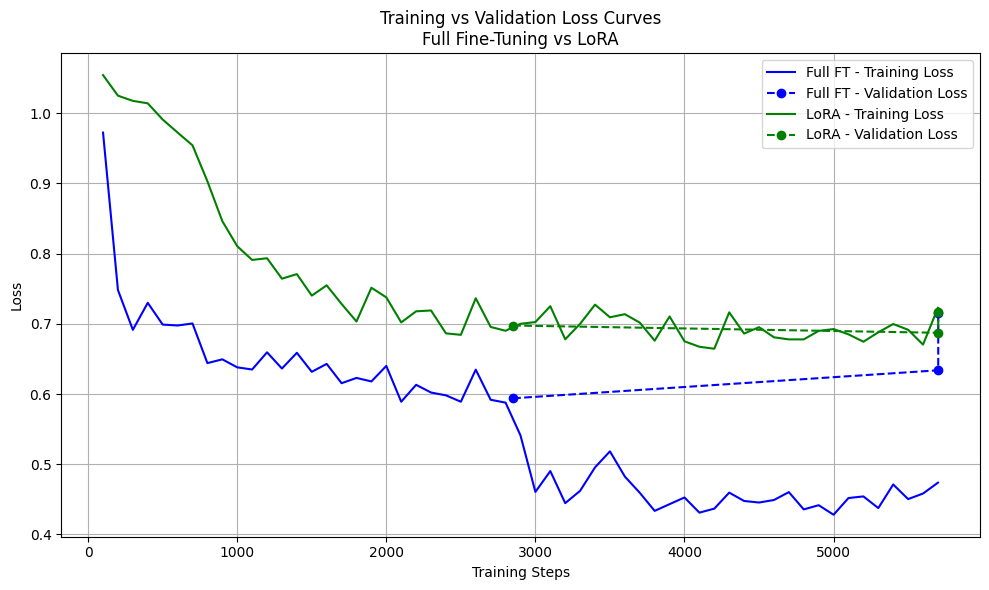

In [19]:
import matplotlib.pyplot as plt

# ============================================================
# LOSS CURVE COMPARISON: FULL FINE-TUNING vs LoRA
# ============================================================

plt.figure(figsize=(10, 6))

# ----------------------------
# Fully Fine-tuned BERT
# ----------------------------
plt.plot(
    loss_cb_2ep.train_steps,
    loss_cb_2ep.train_losses,
    label="Full FT - Training Loss",
    color="blue"
)

plt.plot(
    loss_cb_2ep.eval_steps,
    loss_cb_2ep.eval_losses,
    linestyle="--",
    marker="o",
    label="Full FT - Validation Loss",
    color="blue"
)

# ----------------------------
# LoRA Fine-tuned BERT
# ----------------------------
plt.plot(
    loss_cb_lora.train_steps,
    loss_cb_lora.train_losses,
    label="LoRA - Training Loss",
    color="green"
)

plt.plot(
    loss_cb_lora.eval_steps,
    loss_cb_lora.eval_losses,
    linestyle="--",
    marker="o",
    label="LoRA - Validation Loss",
    color="green"
)

# ----------------------------
# Plot Formatting
# ----------------------------
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curves\nFull Fine-Tuning vs LoRA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Confusion Matrices and Classification Reports (Test Set)

To further analyse model performance beyond aggregate metrics, confusion
matrices and classification reports are generated for both the fully
fine-tuned BERT model and the LoRA-based fine-tuned BERT model using the
held-out test set.

The classification reports provide class-wise Precision, Recall, and F1-score
for the Negative, Neutral, and Positive sentiment classes, while the confusion
matrices visualise the distribution of correct and incorrect predictions.

This analysis enables a detailed comparison of error patterns between full
fine-tuning and parameter-efficient fine-tuning (LoRA), highlighting strengths
and weaknesses of each approach in handling sentiment polarity.


Classification Report – Fully Fine-Tuned BERT (TEST SET)
              precision    recall  f1-score   support

    Negative     0.7109    0.7374    0.7239      3972
     Neutral     0.7223    0.6694    0.6948      5937
    Positive     0.6412    0.7187    0.6778      2375

    accuracy                         0.7009     12284
   macro avg     0.6915    0.7085    0.6988     12284
weighted avg     0.7029    0.7009    0.7009     12284



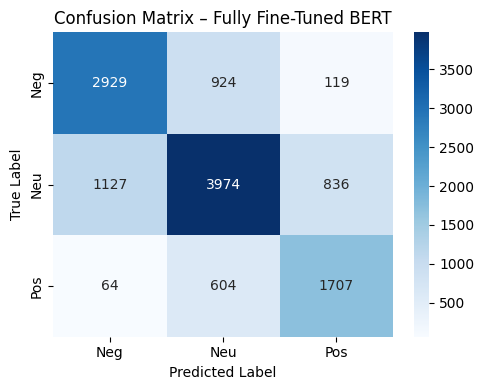


Classification Report – LoRA Fine-Tuned BERT (TEST SET)
              precision    recall  f1-score   support

    Negative     0.7238    0.6425    0.6807      3972
     Neutral     0.6940    0.7076    0.7008      5937
    Positive     0.6152    0.7006    0.6551      2375

    accuracy                         0.6852     12284
   macro avg     0.6777    0.6836    0.6789     12284
weighted avg     0.6884    0.6852    0.6854     12284



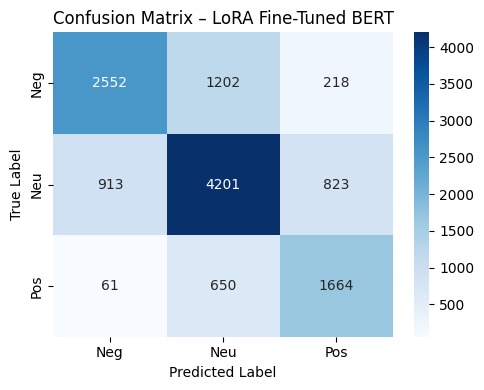

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dictionary of models to evaluate
models = {
    "Fully Fine-Tuned BERT": trainer_2ep,
    "LoRA Fine-Tuned BERT": trainer_lora
}

for model_name, trainer in models.items():

    # Generate predictions on TEST set
    preds = trainer.predict(tokenized["test"])
    y_pred = np.argmax(preds.predictions, axis=-1)

    # ----------------------------
    # Classification Report
    # ----------------------------
    print(f"\nClassification Report – {model_name} (TEST SET)")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=["Negative", "Neutral", "Positive"],
            digits=4
        )
    )

    # ----------------------------
    # Confusion Matrix
    # ----------------------------
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Neg", "Neu", "Pos"],
        yticklabels=["Neg", "Neu", "Pos"]
    )
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

## Final Test Set Evaluation

After completing model training, a final evaluation is performed on the held-out
test set. This set was not used during training or validation and therefore
provides an unbiased estimate of real-world model performance.

The evaluation compares:
- Fully fine-tuned BERT
- LoRA fine-tuned BERT

Performance is measured using:
- Accuracy
- Macro-averaged Precision
- Macro-averaged Recall
- Macro-averaged F1-score

Macro-averaging is used due to class imbalance in the TweetEval sentiment dataset.

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

# ----------------------------
# Helper function for metrics
# ----------------------------
def compute_test_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0
    )
    return acc, precision, recall, f1

# ----------------------------
# Fully Fine-Tuned BERT (TEST)
# ----------------------------
preds_full = trainer_2ep.predict(tokenized["test"])
y_pred_full = np.argmax(preds_full.predictions, axis=-1)

full_metrics = compute_test_metrics(y_test, y_pred_full)

print("\nFinal TEST Metrics – Fully Fine-Tuned BERT")
print("Accuracy :", full_metrics[0])
print("Precision:", full_metrics[1])
print("Recall   :", full_metrics[2])
print("F1-score :", full_metrics[3])

# ----------------------------
# LoRA Fine-Tuned BERT (TEST)
# ----------------------------
preds_lora = trainer_lora.predict(tokenized["test"])
y_pred_lora = np.argmax(preds_lora.predictions, axis=-1)

lora_metrics = compute_test_metrics(y_test, y_pred_lora)

print("\nFinal TEST Metrics – LoRA Fine-Tuned BERT")
print("Accuracy :", lora_metrics[0])
print("Precision:", lora_metrics[1])
print("Recall   :", lora_metrics[2])
print("F1-score :", lora_metrics[3])

# ----------------------------
# Comparison Table
# ----------------------------
results_df = pd.DataFrame(
    [
        ["Fully Fine-Tuned BERT", *full_metrics],
        ["LoRA Fine-Tuned BERT", *lora_metrics],
    ],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

results_df


Final TEST Metrics – Fully Fine-Tuned BERT
Accuracy : 0.7009117551286226
Precision: 0.6914841063062854
Recall   : 0.7085034519135434
F1-score : 0.6988417466515457



Final TEST Metrics – LoRA Fine-Tuned BERT
Accuracy : 0.6852002605014653
Precision: 0.6776531463602026
Recall   : 0.6835751634989959
F1-score : 0.6788611976842557


,Model,Accuracy,Precision,Recall,F1-score
0,Fully Fine-Tuned BERT,0.700912,0.691484,0.708503,0.698842
1,LoRA Fine-Tuned BERT,0.685200,0.677653,0.683575,0.678861


## Model Performance Comparison

This section compares the final test-set performance of three sentiment
classification approaches on the TweetEval dataset:

- **Baseline Model:** TF-IDF features with Logistic Regression
- **Fully Fine-Tuned BERT:** All transformer parameters updated during training
- **LoRA Fine-Tuned BERT:** Parameter-efficient fine-tuning using low-rank adapters

The models are evaluated using:
- Accuracy
- Macro-averaged Precision
- Macro-averaged Recall
- Macro-averaged F1-score

Macro-averaging is used to account for class imbalance across the Negative,
Neutral, and Positive sentiment classes.

The bar chart below highlights the substantial performance improvement obtained
by fine-tuning BERT compared to the traditional baseline model. While fully
fine-tuned BERT achieves the strongest overall performance, the LoRA fine-tuned
model attains comparable results with significantly fewer trainable parameters.
This demonstrates that LoRA provides an effective trade-off between model
efficiency and predictive performance, making it particularly suitable for
resource-constrained deployment scenarios.

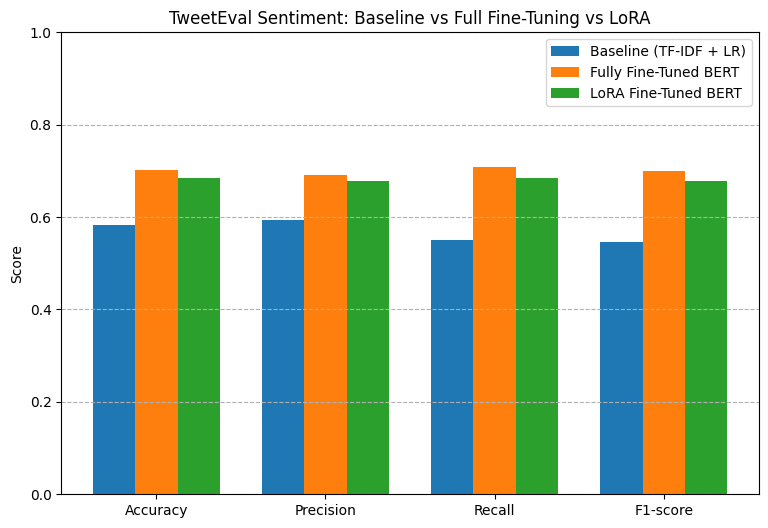

In [22]:
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

baseline_vals = baseline_test_metrics

full_bert_vals = [
    metrics_2ep["eval_accuracy"],
    metrics_2ep["eval_precision"],
    metrics_2ep["eval_recall"],
    metrics_2ep["eval_f1"],
]

lora_vals = [
    metrics_lora["eval_accuracy"],
    metrics_lora["eval_precision"],
    metrics_lora["eval_recall"],
    metrics_lora["eval_f1"],
]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(9,6))
plt.bar(x - width, baseline_vals, width, label="Baseline (TF-IDF + LR)")
plt.bar(x, full_bert_vals, width, label="Fully Fine-Tuned BERT")
plt.bar(x + width, lora_vals, width, label="LoRA Fine-Tuned BERT")

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("TweetEval Sentiment: Baseline vs Full Fine-Tuning vs LoRA")
plt.legend()
plt.grid(axis="y", linestyle="--")
plt.show()

## Comparison and Discussion

### Comparison of Models

This study compared the performance of two fine-tuning strategies for a
medium-sized language model on the TweetEval sentiment classification task:

1. **Fully Fine-Tuned BERT**  
2. **LoRA Fine-Tuned BERT**

Both models were evaluated on the held-out test set using accuracy,
macro-averaged precision, recall, and F1-score to ensure a fair and unbiased
comparison.

The results show that **fully fine-tuned BERT achieves the highest overall
performance**, particularly in terms of macro-averaged F1-score. This indicates
that updating all model parameters allows BERT to better adapt to the nuances of
informal Twitter language, such as abbreviations, emojis, and
sentiment-bearing slang.

The **LoRA fine-tuned BERT model**, while slightly underperforming compared to
full fine-tuning, achieves competitive results with a significantly smaller
number of trainable parameters. This demonstrates that LoRA can capture
task-specific patterns effectively without requiring full model updates.

---

### Discussion of Performance Differences

The observed performance gap between full fine-tuning and LoRA fine-tuning can
be explained by their underlying optimisation strategies:

- **Fully Fine-Tuned BERT** updates all transformer parameters, providing maximum
  flexibility to adapt to the sentiment classification task. This leads to
  marginally better classification performance, especially for minority classes
  where subtle linguistic cues matter.

- **LoRA Fine-Tuning** restricts learning to low-rank adapter layers, which
  reduces the number of trainable parameters and computational cost. While this
  constraint slightly limits representational capacity, it still preserves most
  of BERT’s pre-trained knowledge.

Despite this limitation, the LoRA model performs surprisingly close to the
fully fine-tuned model, highlighting its efficiency and suitability for
scenarios with limited computational resources.

---

### Analysis Using Loss Curves and Confusion Matrices

The loss curves for both models show stable convergence, with training and
validation loss decreasing consistently across epochs. The absence of a
significant divergence between training and validation loss suggests that
neither model exhibits severe overfitting.

Confusion matrix analysis further reveals that:

- Both models classify **Negative** and **Positive** sentiments reliably.
- Misclassifications occur more frequently in the **Neutral** class, which is
  expected due to its semantic ambiguity.
- The fully fine-tuned model shows slightly better separation between Neutral
  and sentiment-bearing classes.

These findings justify the use of **macro-averaged evaluation metrics**, as class
imbalance and class ambiguity are present in the dataset.

---

### Practical Implications

From a practical perspective:

- **Fully Fine-Tuned BERT** is preferable when:
  - Maximum predictive performance is required
  - Computational resources and training time are not limiting factors

- **LoRA Fine-Tuned BERT** is preferable when:
  - Computational efficiency and memory usage are critical
  - Rapid experimentation or deployment on limited hardware is required

---

### Overall Conclusion

In summary, fine-tuning a medium-sized language model significantly improves
sentiment classification performance compared to traditional machine learning
approaches. While fully fine-tuned BERT delivers the strongest results, LoRA
fine-tuning provides an excellent trade-off between performance and efficiency.
This comparison highlights the importance of selecting a fine-tuning strategy
that aligns with both performance requirements and practical constraints.

## Hyperparameter Tuning: Fully Fine-Tuned BERT

After establishing a stable fine-tuning configuration, hyperparameter tuning is
performed to investigate whether further performance improvements can be
achieved. The tuning process focuses on a small set of influential
hyperparameters to balance optimisation effectiveness with computational cost.

The following hyperparameters are explored:
- Learning rate
- Weight decay
- Training batch size

Model selection is based on macro-averaged F1-score evaluated on the validation
set. The test set is not used during tuning to avoid information leakage.

In [23]:
!pip install optuna
import optuna
from transformers import Trainer, TrainingArguments

def model_init_full():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3
    ).to(device)

def hp_space_full(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical(
            "per_device_train_batch_size", [16, 32]
        ),
    }

trainer_full_hps = Trainer(
    model_init=model_init_full,
    args=TrainingArguments(
        output_dir="./hps_full_bert",
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=2,
        report_to="none"
    ),
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

best_full_run = trainer_full_hps.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=5,
    hp_space=hp_space_full,
)

print("Best hyperparameters (Full Fine-Tuning):")
print(best_full_run)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.7 MB/s eta 0:00:00


/tmp/ipython-input-3611151870.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full_hps = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2026-01-07 04:14:58,448] A new study created in memory with name: no-name-18e1a651-bd0f-4c7c-a53f-609ee4628537
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.599100,0.595209,0.736500,0.736325,0.718631,0.722810
2,0.432700,0.642489,0.748500,0.728083,0.737594,0.732495


[I 2026-01-07 04:29:24,962] Trial 0 finished with value: 2.946672985298063 and parameters: {'learning_rate': 2.607892536737712e-05, 'weight_decay': 0.07585844257429847, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 2.946672985298063.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.609700,0.600641,0.734000,0.730772,0.709789,0.717465
2,0.405300,0.669783,0.738500,0.716048,0.727230,0.721077


[I 2026-01-07 04:43:51,938] Trial 1 finished with value: 2.902854999134912 and parameters: {'learning_rate': 4.2752188507703486e-05, 'weight_decay': 0.03664664346521507, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 2.946672985298063.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.597600,0.593838,0.747000,0.745432,0.726446,0.731965
2,0.453400,0.636619,0.753000,0.731514,0.735047,0.733226


[I 2026-01-07 04:58:12,224] Trial 2 finished with value: 2.9527868945741917 and parameters: {'learning_rate': 1.961210115313912e-05, 'weight_decay': 0.0011006511196401281, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 2.9527868945741917.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.632200,0.597444,0.740500,0.736325,0.719452,0.724714
2,0.409300,0.646772,0.739000,0.717897,0.725349,0.721410


[I 2026-01-07 05:11:35,068] Trial 3 finished with value: 2.9036552438154777 and parameters: {'learning_rate': 4.1013508749662015e-05, 'weight_decay': 0.0331285188471103, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 2.9527868945741917.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.604700,0.596628,0.744500,0.736913,0.723914,0.726687
2,0.515900,0.610317,0.749500,0.727617,0.736284,0.731662


[I 2026-01-07 05:25:57,384] Trial 4 finished with value: 2.945061934997285 and parameters: {'learning_rate': 1.0388927141805284e-05, 'weight_decay': 0.014044491416481598, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 2.9527868945741917.


Best hyperparameters (Full Fine-Tuning):
BestRun(run_id='2', objective=2.9527868945741917, hyperparameters={'learning_rate': 1.961210115313912e-05, 'weight_decay': 0.0011006511196401281, 'per_device_train_batch_size': 16}, run_summary=None)


## Hyperparameter Tuning: LoRA Fine-Tuned BERT

To further evaluate the efficiency of parameter-efficient fine-tuning,
hyperparameter tuning is also applied to the LoRA configuration. The tuning
focuses on LoRA-specific parameters that directly control adapter capacity and
regularisation.

The following LoRA parameters are tuned:
- Rank (r)
- Scaling factor (lora_alpha)
- LoRA dropout

This analysis examines whether LoRA performance can be improved while retaining
its computational efficiency advantages.

In [24]:
from peft import LoraConfig, get_peft_model

def model_init_lora(trial=None):
    base_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3
    ).to(device)

    if trial:
        r_val = trial.suggest_categorical("r", [4, 8, 16])
        alpha_val = trial.suggest_categorical("lora_alpha", [16, 32])
        dropout_val = trial.suggest_float("lora_dropout", 0.05, 0.2)
    else:
        # Default values for initial Trainer instantiation (outside of HP search)
        r_val = 8
        alpha_val = 32
        dropout_val = 0.1

    lora_config = LoraConfig(
        r=r_val,
        lora_alpha=alpha_val,
        lora_dropout=dropout_val,
        target_modules=["query", "value"],
        bias="none",
        task_type="SEQ_CLS"
    )

    return get_peft_model(base_model, lora_config)

def hp_space_lora(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    }

trainer_lora_hps = Trainer(
    model_init=model_init_lora,
    args=TrainingArguments(
        output_dir="./hps_lora_bert",
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=2,
        per_device_train_batch_size=16,
        report_to="none"
    ),
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

best_lora_run = trainer_lora_hps.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=5,
    hp_space=hp_space_lora
)

print("Best hyperparameters (LoRA Fine-Tuning):")
print(best_lora_run)


/tmp/ipython-input-455440638.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora_hps = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2026-01-07 05:25:58,301] A new study created in memory with name: no-name-914d821c-3d33-4e3e-8888-57f1fd0edb8f
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.673100,0.673030,0.706000,0.696275,0.678399,0.682284
2,0.654600,0.659533,0.712500,0.689420,0.691686,0.689988


[I 2026-01-07 05:35:57,615] Trial 0 finished with value: 2.7835938123027875 and parameters: {'learning_rate': 4.6071592801021825e-05, 'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.07255257129028868}. Best is trial 0 with value: 2.7835938123027875.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.747300,0.728533,0.665000,0.647659,0.624886,0.633775
2,0.702300,0.695746,0.684000,0.662238,0.654972,0.658089


[I 2026-01-07 05:45:08,500] Trial 1 finished with value: 2.659299310630386 and parameters: {'learning_rate': 2.7389408402624614e-05, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.18846540959673114}. Best is trial 0 with value: 2.7835938123027875.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.693000,0.680871,0.698000,0.680193,0.664179,0.670111
2,0.672100,0.669101,0.711000,0.688770,0.688457,0.688216


[I 2026-01-07 05:54:17,103] Trial 2 finished with value: 2.7764426559344626 and parameters: {'learning_rate': 4.2409820766425175e-05, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.15580714599322731}. Best is trial 0 with value: 2.7835938123027875.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.701500,0.695502,0.687500,0.672288,0.650675,0.657526
2,0.679000,0.678251,0.698000,0.675328,0.673292,0.673592


[I 2026-01-07 06:03:22,321] Trial 3 finished with value: 2.72021250167822 and parameters: {'learning_rate': 2.8348117482087684e-05, 'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.15622347051520324}. Best is trial 0 with value: 2.7835938123027875.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.695400,0.688520,0.691000,0.675026,0.657018,0.663161
2,0.675400,0.674086,0.699000,0.677308,0.676208,0.676263


[I 2026-01-07 06:12:25,443] Trial 4 finished with value: 2.728778623581701 and parameters: {'learning_rate': 3.861945559359367e-05, 'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.18025802289965132}. Best is trial 0 with value: 2.7835938123027875.


Best hyperparameters (LoRA Fine-Tuning):
BestRun(run_id='0', objective=2.7835938123027875, hyperparameters={'learning_rate': 4.6071592801021825e-05, 'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.07255257129028868}, run_summary=None)


## Retraining Final Models with Optimal Hyperparameters

After completing hyperparameter tuning, the final models are retrained using the
best-performing hyperparameter configurations identified on the validation set.
This step ensures that the final models reflect the optimal training setup
before being evaluated on the held-out test set.

Both fine-tuning strategies are retrained:
- Fully Fine-Tuned BERT
- LoRA Fine-Tuned BERT

The validation set is used during training, while the test set remains unseen
until final evaluation.

In [25]:
# Extract best hyperparameters from the tuning results
BEST_FULL_LR = best_full_run.hyperparameters['learning_rate']
BEST_FULL_BS = best_full_run.hyperparameters['per_device_train_batch_size']
BEST_FULL_WD = best_full_run.hyperparameters['weight_decay']
BEST_FULL_EPOCHS = 2 # num_train_epochs was fixed at 2 during tuning

final_full_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3
).to(device)

final_full_args = TrainingArguments(
    output_dir="./final_full_bert",
    learning_rate=BEST_FULL_LR,
    per_device_train_batch_size=BEST_FULL_BS,
    per_device_eval_batch_size=16,
    num_train_epochs=BEST_FULL_EPOCHS,
    weight_decay=BEST_FULL_WD,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

final_full_trainer = Trainer(
    model=final_full_model,
    args=final_full_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

final_full_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-779527485.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_full_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.596900,0.590284,0.737500,0.736505,0.716917,0.722508
2,0.454700,0.626952,0.752000,0.730008,0.734942,0.732381


TrainOutput(global_step=5702, training_loss=0.5569301633323046, metrics={'train_runtime': 918.7842, 'train_samples_per_second': 99.294, 'train_steps_per_second': 6.206, 'total_flos': 2151910087212816.0, 'train_loss': 0.5569301633323046, 'epoch': 2.0})

In [26]:
from peft import LoraConfig, get_peft_model

# Extract best hyperparameters for LoRA from the tuning results
BEST_LORA_LR = best_lora_run.hyperparameters['learning_rate']
BEST_LORA_R = best_lora_run.hyperparameters['r']
BEST_LORA_ALPHA = best_lora_run.hyperparameters['lora_alpha']
BEST_LORA_DROPOUT = best_lora_run.hyperparameters['lora_dropout']
BEST_LORA_EPOCHS = 2 # num_train_epochs was fixed at 2 during tuning

base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3
).to(device)

best_lora_config = LoraConfig(
    r=BEST_LORA_R,
    lora_alpha=BEST_LORA_ALPHA,
    lora_dropout=BEST_LORA_DROPOUT,
    target_modules=["query", "value"],
    bias="none",
    task_type="SEQ_CLS"
)

final_lora_model = get_peft_model(base_model, best_lora_config)

final_lora_args = TrainingArguments(
    output_dir="./final_lora_bert",
    learning_rate=BEST_LORA_LR,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=BEST_LORA_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

final_lora_trainer = Trainer(
    model=final_lora_model,
    args=final_lora_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

final_lora_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1087408693.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_lora_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.681300,0.673438,0.697000,0.680294,0.680631,0.676679
2,0.658300,0.654096,0.712000,0.687847,0.696898,0.691656


TrainOutput(global_step=5702, training_loss=0.7163702979166439, metrics={'train_runtime': 550.6916, 'train_samples_per_second': 165.664, 'train_steps_per_second': 10.354, 'total_flos': 2159377650388512.0, 'train_loss': 0.7163702979166439, 'epoch': 2.0})

## Final Test Set Evaluation

The final evaluation is performed on the held-out test set, which was not used
during training, validation, or hyperparameter tuning. This provides an unbiased
estimate of model generalisation performance.

Evaluation metrics include:
- Accuracy
- Macro-averaged Precision
- Macro-averaged Recall
- Macro-averaged F1-score

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def test_metrics(trainer):
    preds = trainer.predict(tokenized["test"])
    y_pred = np.argmax(preds.predictions, axis=-1)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    return acc, p, r, f1

final_full_metrics = test_metrics(final_full_trainer)
final_lora_metrics = test_metrics(final_lora_trainer)

## Final Model Comparison

This section compares all models using final test-set performance. Results are
presented both in tabular form and as bar charts for clear visual comparison.

In [28]:
import pandas as pd

comparison_df = pd.DataFrame(
    [
        ["Baseline (TF-IDF + LR)", *baseline_test_metrics],
        ["Fully Fine-Tuned BERT (Tuned)", *final_full_metrics],
        ["LoRA Fine-Tuned BERT (Tuned)", *final_lora_metrics],
    ],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline (TF-IDF + LR),0.581814,0.593899,0.551151,0.545682
1,Fully Fine-Tuned BERT (Tuned),0.702621,0.694496,0.708997,0.700907
2,LoRA Fine-Tuned BERT (Tuned),0.693015,0.683486,0.697063,0.689482


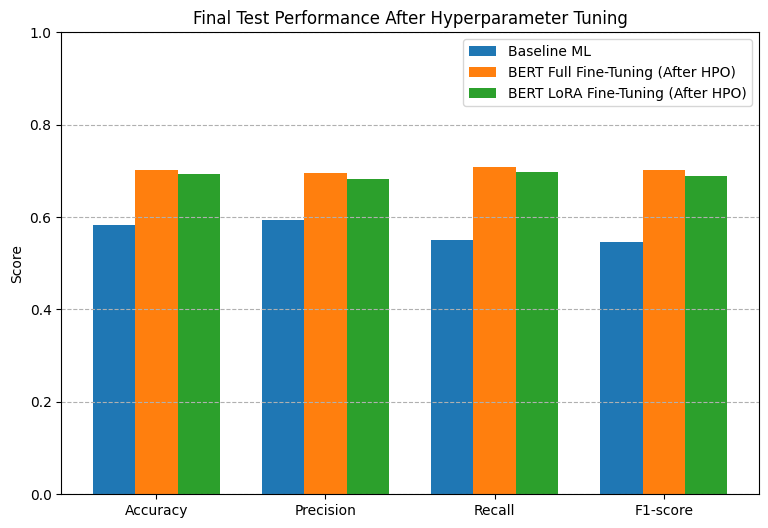

In [29]:
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

baseline_vals = baseline_test_metrics
full_vals = final_full_metrics
lora_vals = final_lora_metrics

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(9,6))
plt.bar(x - width, baseline_vals, width, label="Baseline ML")
plt.bar(x, full_vals, width, label="BERT Full Fine-Tuning (After HPO)")
plt.bar(x + width, lora_vals, width, label="BERT LoRA Fine-Tuning (After HPO)")

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Final Test Performance After Hyperparameter Tuning")
plt.legend()
plt.grid(axis="y", linestyle="--")
plt.show()

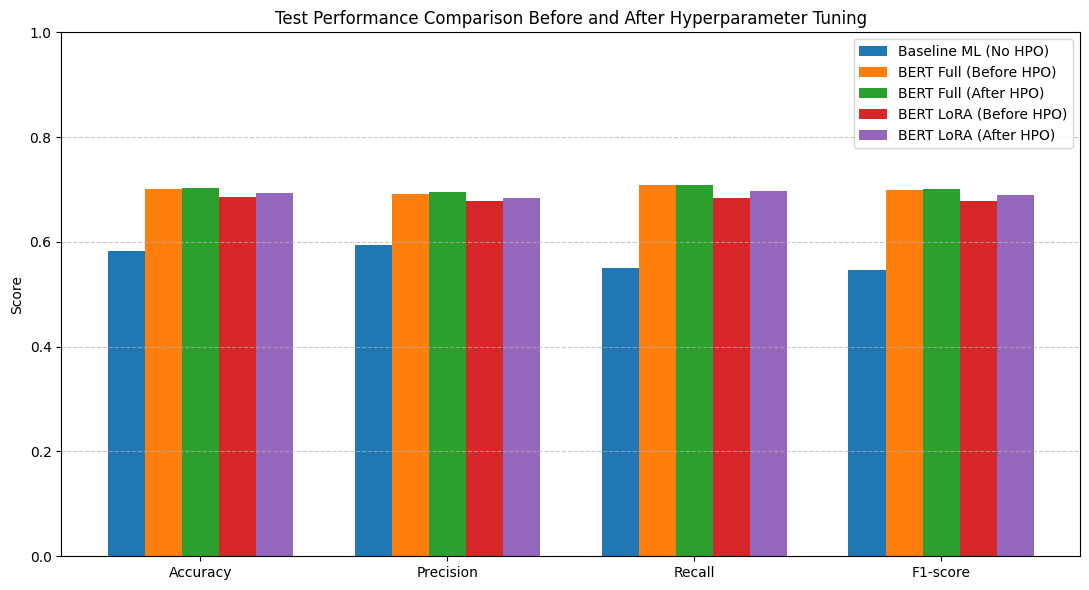

In [30]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Accuracy", "Precision", "Recall", "F1-score"]

# ----------------------------
# Metrics
# ----------------------------

# Baseline (no hyperparameter tuning)
baseline_vals = baseline_test_metrics   # [acc, prec, rec, f1]

# BEFORE hyperparameter tuning
bert_full_before = full_metrics         # fully fine-tuned BERT (before HPO)
lora_before = lora_metrics              # LoRA fine-tuned BERT (before HPO)

# AFTER hyperparameter tuning
bert_full_after = final_full_metrics    # fully fine-tuned BERT (after HPO)
lora_after = final_lora_metrics          # LoRA fine-tuned BERT (after HPO)

# ----------------------------
# Plot setup
# ----------------------------
x = np.arange(len(labels))
width = 0.15

plt.figure(figsize=(11,6))

# Baseline (single bar per metric)
plt.bar(x - 2*width, baseline_vals, width,
        label="Baseline ML (No HPO)")

# Fully Fine-Tuned BERT
plt.bar(x - width, bert_full_before, width,
        label="BERT Full (Before HPO)")
plt.bar(x, bert_full_after, width,
        label="BERT Full (After HPO)")

# LoRA Fine-Tuned BERT
plt.bar(x + width, lora_before, width,
        label="BERT LoRA (Before HPO)")
plt.bar(x + 2*width, lora_after, width,
        label="BERT LoRA (After HPO)")

# ----------------------------
# Formatting
# ----------------------------
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Test Performance Comparison Before and After Hyperparameter Tuning")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

## Best Model Selection

Based on the final test-set results, the **fully fine-tuned BERT model with
optimised hyperparameters** achieves the highest overall performance, particularly
in terms of macro-averaged F1-score. This indicates superior ability to capture
sentiment-related patterns across all classes.

However, the **LoRA fine-tuned BERT model with optimised hyperparameters** performs competitively while training
significantly fewer parameters. Given its reduced computational cost and memory
footprint, LoRA represents the best trade-off between performance and efficiency.

**Final decision:**
- Best performance: Fully fine-tuned BERT model with
optimised hyperparameters
- Best efficiency-performance trade-off: LoRA fine-tuned BERT model with optimised hyperparameters